In [ ]:
%gui qt

In [1]:
import napari
import sys
Linux = True
if Linux:
    sys.path.insert(0,'/home/georgeos/Documents/GitHub/SYMPTOMM2')
else:
    sys.path.insert(0,'C:\\Users\\gh464\\Documents\\GitHub\\SYMPTOMM2\\')
from SYMPTOMM.cell import Cell
from SYMPTOMM.scene_functions import create_space, step_and_update
from SYMPTOMM.trench_geometry import trench_creator
from SYMPTOMM.phase_contrast_drawing import *
import tifffile
import numpy as np
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, resize, downscale_local_mean
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from skimage.exposure import rescale_intensity
from ipywidgets import interactive
import os
from PIL import Image
import skimage
from tqdm.notebook import tqdm
import gc
from SYMPTOMM.PSF import get_phase_contrast_kernel, get_condensers


#viewer = napari.view_image(real_image)


In [3]:
real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/real_data/Lane_02_pos_001_trench_x_0266_y_0059_w_0046_h_0460_c_Phase.tif")

In [4]:
real_image = real_image[0,:256,:]

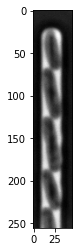

In [5]:
plt.imshow(real_image,cmap="Greys_r")

In [6]:
real_image.shape

(256, 46)

In [7]:
#real_image = tifffile.imread("/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/Lane_02_pos_002_trench_x_1963_y_0067_w_0046_h_0460_c_Phase.tif")[0][:300,:]


### Scope props

In [8]:
condensers = get_condensers()
W, R, diameter = condensers["Ph2"]
radius=50
#F = 5
λ = 0.75
resize_amount = 3
pix_mic_conv = 0.0655 ##0.108379937 micron/pix for 60x, 0.0655 for 100x
scale = pix_mic_conv / resize_amount 
min_sigma = 0.42*0.6/6 / scale # micron#
sigma=min_sigma
NA=1.45
n = 1.4
kernel_params = (R,W,radius,scale,NA,n,sigma,λ)

#kernel_params = (R,W,radius,scale,F,sigma,λ)


In [9]:
def run_simulation(trench_length, trench_width, cell_max_length, cell_width, sim_length, pix_mic_conv, gravity, phys_iters, max_length_var, width_var):
    
    
    space = create_space()
    space.gravity = 0, gravity # arbitrary units, negative is toward trench pole
    dt = 1/100 #time-step per frame
    pix_mic_conv = 1/pix_mic_conv # micron per pixel
    scale_factor = pix_mic_conv * 3 # resolution scaling factor 

    trench_length = trench_length*scale_factor
    trench_width = trench_width*scale_factor
    trench_creator(trench_width,trench_length,(35,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*3,0),space) # Coordinates of bottom left corner of the trench
    #trench_creator(35,trench_length,(35*5,0),space) # Coordinates of bottom left corner of the trench

    cell1 = Cell(
        length = cell_max_length*scale_factor,  
        width = cell_width*scale_factor, 
        resolution = 60, 
        position = (20+35,40), 
        angle = 0.8, 
        space = space,
        dt = 1/60,
        growth_rate_constant = 1,
        max_length = cell_max_length*scale_factor,
        max_length_mean =cell_max_length*scale_factor,
        max_length_var = max_length_var*np.sqrt(scale_factor),
        width_var = width_var*np.sqrt(scale_factor),
        width_mean = cell_width*scale_factor
    )


    cells = [cell1]
    cell_timeseries = []
    phys_iters = phys_iters
    for x in tqdm(range(sim_length+250),desc="Simulation Progress"):
        cells = step_and_update(dt=dt, cells=cells, space=space, phys_iters=phys_iters,ylim=trench_length)
        if x > 250:
            cell_timeseries.append(deepcopy(cells))
    return cell_timeseries, space

### Do very long cells

In [11]:
sim_length = 700
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.55, 
    cell_max_length=6, 
    cell_width=1.1, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-2,
    phys_iters=19,
    max_length_var = 1.5,
    width_var = 0.1
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Simulation Progress:   0%|          | 0/950 [00:00<?, ?it/s]

Timeseries Properties:   0%|          | 0/699 [00:00<?, ?it/s]

Scene Draw::   0%|          | 0/699 [00:00<?, ?it/s]

In [12]:
gc.collect()

7314

In [18]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 3
x_border_expansion_coefficient = 3



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient
)



### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)

real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:105: RuntimeWarning: invalid value encountered in true_divide
  kernel1 = 2*jv(1,rr)/(rr)
/home/georgeos/Documents/GitHub/SYMPTOMM2/SYMPTOMM/PSF.py:108: RuntimeWarning: invalid value encountered in true_divide
  kernel2 = 2*(R-W)**2/R**2 * jv(1,(R-W)**2/R**2 * rr)/rr
<ipython-input-18-c7398cafaa64>:28: RuntimeWarning: Mean of empty slice.
  real_media_mean = real_resize[np.where(media_label.data)].mean();
/home/georgeos/.local/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
<ipython-input-18-c7398cafaa64>:29: RuntimeWarning: Mean of empty slice.
  real_cell_mean = real_resize[np.where(cell_label.data)].mean();
<ipython-input-18-c7398cafaa64>:30: RuntimeWarning: Mean of empty slice.
  real_device_mean = real_resize[np.where(device_label.data)].mean()
<ipython-input-18-c7398cafaa64>:33: RuntimeWarning: Degrees of freedom <= 0 f

In [19]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [20]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [22]:
generate_training_data(interactive_output = params, sample_amount = 0.0075, randomise_hist_match = True, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  10000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data_exponential/")

Sample generation: 100%|██████████| 10000/10000 [36:29<00:00,  4.57it/s]


### Do high variance + large cells

In [175]:
sim_length = 300
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.55, 
    cell_max_length=4.7, 
    cell_width=1.1, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-2,
    phys_iters=19,
    max_length_var = 7,
    width_var = 0.09
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))




Simulation Progress:   0%|          | 0/550 [00:00<?, ?it/s]


Simulation Progress:   6%|▌         | 31/550 [00:00<00:01, 308.45it/s]


Simulation Progress:  11%|█▏        | 62/550 [00:00<00:01, 250.25it/s]


Simulation Progress:  16%|█▌        | 88/550 [00:00<00:02, 209.98it/s]


Simulation Progress:  20%|██        | 110/550 [00:00<00:02, 159.75it/s]


Simulation Progress:  23%|██▎       | 128/550 [00:00<00:03, 136.04it/s]


Simulation Progress:  26%|██▌       | 143/550 [00:00<00:03, 122.39it/s]


Simulation Progress:  28%|██▊       | 156/550 [00:01<00:03, 110.83it/s]


Simulation Progress:  31%|███       | 168/550 [00:01<00:03, 108.93it/s]


Simulation Progress:  33%|███▎      | 180/550 [00:01<00:03, 110.30it/s]


Simulation Progress:  35%|███▍      | 192/550 [00:01<00:03, 104.15it/s]


Simulation Progress:  37%|███▋      | 203/550 [00:01<00:03, 98.48it/s] 


Simulation Progress:  39%|███▊      | 213/550 [00:01<00:03, 98.40it/s]


Simulation Progress:  41%|████      | 224/550 [00:

In [176]:
media_multiplier=30
cell_multiplier=1
device_multiplier=-50
y_border_expansion_coefficient = 3
x_border_expansion_coefficient = 3



temp_expanded_scene, temp_expanded_scene_no_cells, temp_expanded_mask = generate_PC_OPL(
   main_segments=main_segments,
    offset=offset,
    scene = scenes[0][0],
    mask = scenes[0][1],
    media_multiplier=media_multiplier,
    cell_multiplier=cell_multiplier,
    device_multiplier=cell_multiplier,
    y_border_expansion_coefficient = y_border_expansion_coefficient,
    x_border_expansion_coefficient = x_border_expansion_coefficient
)



### Generate temporary image to make same shape
temp_kernel = get_phase_contrast_kernel(*kernel_params)
convolved = convolve_rescale(temp_expanded_scene, temp_kernel, 1/resize_amount, rescale_int = True)
real_resize, expanded_resized = make_images_same_shape(real_image,convolved, rescale_int=True)



In [16]:
viewer = napari.view_image(real_resize)
media_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "media")
cell_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "cell")
device_label = viewer.add_labels(np.zeros(real_resize.shape).astype(int), name = "device")

In [100]:
real_media_mean = real_resize[np.where(media_label.data)].mean();
real_cell_mean = real_resize[np.where(cell_label.data)].mean(); 
real_device_mean = real_resize[np.where(device_label.data)].mean()
real_means = np.array((real_media_mean, real_cell_mean, real_device_mean))

real_media_var = real_resize[np.where(media_label.data)].var();
real_cell_var = real_resize[np.where(cell_label.data)].var(); 
real_device_var = real_resize[np.where(device_label.data)].var()
real_vars = np.array((real_media_var, real_cell_var, real_device_var))

image_params = (real_media_mean, real_cell_mean, real_device_mean, real_means, real_media_var, real_cell_var, real_device_var, real_vars)

In [179]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [180]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [181]:
generate_training_data(interactive_output = params, sample_amount = 0.025, randomise_hist_match = True, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  5000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data/")

Sample generation: 100%|██████████| 5000/5000 [17:31<00:00,  4.75it/s]


### Do long cells low var

In [188]:
sim_length = 300
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=4.7, 
    cell_width=1.09, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-4,
    phys_iters=35,
    max_length_var = 2,
    width_var = 0.06
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = True
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Scene Draw:: 100%|██████████| 299/299 [02:04<00:00,  2.40it/s]


In [190]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [191]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [192]:
generate_training_data(interactive_output = params, sample_amount = 0.025, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  1000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data/")

Sample generation: 100%|██████████| 1000/1000 [03:26<00:00,  4.84it/s]


## Do small cells

In [198]:
sim_length = 100
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.5, 
    cell_max_length=2.8, 
    cell_width=1.05, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-7,
    phys_iters=25,
    max_length_var = 2,
    width_var = 0.06
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 30
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Scene Draw:: 100%|██████████| 99/99 [00:57<00:00,  1.71it/s]


In [195]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [196]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [200]:
generate_training_data(interactive_output = params, sample_amount = 0.025, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  1000, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data/")


Sample generation:  28%|██▊       | 277/1000 [00:56<02:26,  4.93it/s]

KeyboardInterrupt: 

### Do a few very small cells

In [230]:
sim_length = 40
cell_timeseries, space = run_simulation(
    trench_length=15, 
    trench_width=1.45, 
    cell_max_length=1.4, 
    cell_width=1.05, 
    sim_length = sim_length, 
    pix_mic_conv = pix_mic_conv,
    gravity=-1,
    phys_iters=450,
    max_length_var = 0.1,
    width_var = 0.08
) # growth phase
main_segments = get_trench_segments(space)
ID_props = generate_curve_props(cell_timeseries)
cell_timeseries_properties = Parallel(n_jobs=-1)(
    delayed(gen_cell_props_for_draw)(a, ID_props) for a in tqdm(cell_timeseries, desc='Timeseries Properties'))
do_transformation = False
offset = 40
mask_threshold = 18
label_masks = True
space_size = get_space_size(cell_timeseries_properties)
scenes = Parallel(n_jobs=-1)(delayed(draw_scene)(
    cell_properties, do_transformation, mask_threshold, space_size, offset, label_masks) for cell_properties in tqdm(cell_timeseries_properties, desc='Scene Draw:'))

Scene Draw:: 100%|██████████| 39/39 [00:17<00:00,  2.25it/s]


In [233]:
mean_error = []
media_error = []
cell_error = []
device_error = []

mean_var_error = []
media_var_error = []
cell_var_error = []
device_var_error = []

error_params = (mean_error,media_error,cell_error,device_error,mean_var_error,media_var_error,cell_var_error,device_var_error)

params = interactive(
    generate_test_comparison,
    media_multiplier=(-300,300,1),
    cell_multiplier=(-30,30,0.01),
    device_multiplier=(-300,300,1),
    sigma=(min_sigma,min_sigma*20, min_sigma/20),
    scene_no = (0,sim_length-2,1),
    noise_var=(0,0.01, 0.0001),
    scale=(scale,scale,scale),
    match_histogram = [True, False],
    match_noise = [True, False],
    offset=fixed(offset),
    main_segments = fixed(main_segments),
    debug_plot=fixed(True),
    scenes = fixed(scenes),
    kernel_params = fixed(kernel_params),
    resize_amount = fixed(resize_amount), 
    real_image = fixed(real_image),
    image_params = fixed(image_params),
    error_params = fixed(error_params),
    x_border_expansion_coefficient = fixed(x_border_expansion_coefficient),
    y_border_expansion_coefficient = fixed(y_border_expansion_coefficient)
);

In [234]:
params

interactive(children=(IntSlider(value=0, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [235]:
generate_training_data(interactive_output = params, sample_amount = 0.015, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  100, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data/")

Sample generation: 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


### Do a few empty trenches with different sizes

Rememebr to set `cell_multiplier` to 0

In [236]:
params

interactive(children=(IntSlider(value=3, description='media_multiplier', max=300, min=-300), FloatSlider(value…

In [237]:
generate_training_data(interactive_output = params, sample_amount = 0.1, randomise_hist_match = False, randomise_noise_match = False, sim_length = sim_length, burn_in = 0, n_samples =  15, save_dir = "/home/georgeos/Storage/Dropbox (Cambridge University)/Phase/training_data/")

Sample generation:   0%|          | 0/15 [00:00<?, ?it/s]<ipython-input-171-73e8c3158a79>:314: RuntimeWarning: Mean of empty slice.
  simulated_means = np.array([just_media[np.where(just_media)].mean(), just_cells[np.where(just_cells)].mean(), just_device[np.where(just_device)].mean()])
<ipython-input-171-73e8c3158a79>:315: RuntimeWarning: Degrees of freedom <= 0 for slice
  simulated_vars = np.array([just_media[np.where(just_media)].var(), just_cells[np.where(just_cells)].var(), just_device[np.where(just_device)].var()])
Sample generation: 100%|██████████| 15/15 [00:02<00:00,  5.05it/s]
